In [1]:
import pandas as pd
import nltk
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from nltk.tokenize.treebank import TreebankWordDetokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize.toktok import ToktokTokenizer
import re
from wordcloud import WordCloud, STOPWORDS



# Connecting to MongoDB

In [2]:
from pymongo import MongoClient
client = MongoClient('localhost:27017')

mydb = client['BAX422']

mycol= mydb['games']
temp = []
review =[]
dictionary = {}
flat_list = []
def count(elements):
    # check if each word has '.' at its last. If so then ignore '.'
    if elements[-1] == '.':
        elements = elements[0:len(elements) - 1]
   
    # if there exists a key as "elements" then simply
    # increase its value.
    if elements in dictionary:
        dictionary[elements] += 1
   
    # if the dictionary does not have the key as "elements" 
    # then create a key "elements" and assign its value to 1.
    else:
        dictionary.update({elements: 1})

##3List of genres
genre_list=['Action','Adventure','Indie','RPG','Shooter','Simulation','Sports','Racing','Casual','Puzzle']
#{"name":"gamename"}

##extracting all reviews for genre Strategy and save it in a list of list call review
for x in mycol.find({ "genres.name":  "Strategy" },{"_id":0,"user_reviews":1}):
    for n in x.values():
        temp=list(n.values())
    review.append(temp)
    temp=[]
    

##flatting out review to a flat list            
for sublist in review:
    for subsublist in sublist:
        for x in subsublist['review_text']:
            flat_list.append(x)
            
##calling a function to do word counts and create a dictionary
for elements in flat_list:
    count(elements)

##extracting the key and values which will be the word and the frequency
word = dictionary.keys()
count = dictionary.values()

##putting it into a pd df
pdf = pd.DataFrame(list(zip(word,count)),columns =['word', 'count'])

##exporting top 30 words sorted by frequency descending
#pdf.sort_values(by=['count'],ascending=False).head(50)

# Data Preprocessing

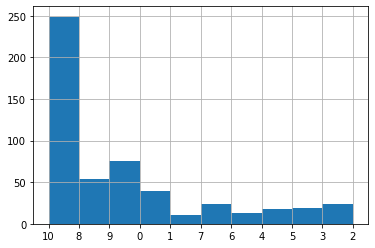

In [3]:

score_list=[]

for i in review:
    for j in i:
        score_list.append(j)
        data=pd.DataFrame(score_list)


new_data=data
new_data['review_score'].hist(figsize=(6,4))
new_data=new_data[new_data['review_score']!='']
new_data['review_score']=new_data['review_score'].astype(str).astype(int)

In [4]:
#Assign labels to the data based on ratings
new_data.loc[new_data['review_score']<=4,'review_label']= "Negative"
new_data.loc[(new_data['review_score']>4) & (new_data['review_score']<= 7),'review_label']="Neutral"
new_data.loc[new_data['review_score']>7,'review_label']="Positive"


<AxesSubplot:>

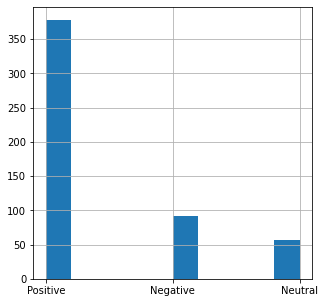

In [5]:
new_data['review_label'].hist(figsize=(5,5))

In [6]:
###Forming custom stoplist containing English and Spanish Stopwords

nltk.download('stopwords')
from nltk.corpus import stopwords
stopword_en = stopwords.words('english')
stopword_es = stopwords.words('spanish')
stopword = stopword_en + stopword_es
#new_data['review_label']=new_data['review_label'].astype(int)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
nw_lst=[]

for p in new_data['review_text']:
    nw_lst.append(TreebankWordDetokenizer().detokenize(p))
    
    
new_data['review_text']=pd.DataFrame(nw_lst)


# Data Cleaning 

In [8]:
word_cloud=new_data.copy()
#Function for removing the stopwords
tokenizer=ToktokTokenizer()
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
word_cloud['review_text']=word_cloud['review_text'].apply(remove_stopwords)



In [9]:
#Function for removing all alphanumeric characters and string less than 4 characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'\b\w{1,3}\b'
    text=re.sub(pattern,'',text)
    text=re.sub(r"[0-9]+[a-z]+","",text)
    return text
#Apply function on review column
word_cloud['review_text']=word_cloud['review_text'].apply(remove_special_characters)

In [10]:
#Function for removing irrelevant  words
ignoreList=['game','games','gaming','much','play','played','great','really','seem','gets','thing','beta','must','makes','time','better','even','first','well','lot','way','playing','made','every','still','also','make','cant','like','good','ever','seen','best','amazing','since','could','nothing','using','else','huge','people','without','overall','reviews','reviewers','review','get','prepared','button']
def remove_notimportantwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in ignoreList]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in ignoreList]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
word_cloud['review_text']=word_cloud['review_text'].apply(remove_notimportantwords)



# WordCloud

In [11]:
Positive_text=word_cloud[word_cloud['review_label']=="Positive"]
Negative_text=word_cloud[word_cloud['review_label']=="Negative"]
Neutral_text=word_cloud[word_cloud['review_label']=="Neutral"]

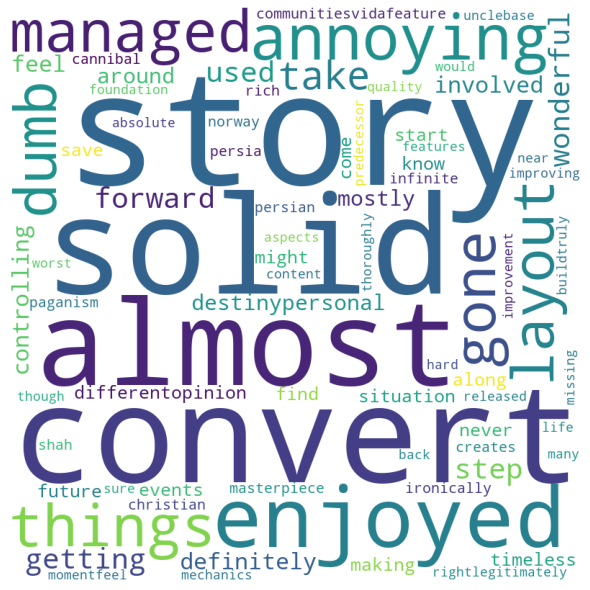

In [12]:
##Generating Word Cloud for Positive sentiment reviews
stopwords = set(STOPWORDS)

descriptions = list(Positive_text['review_text'])
all_words = ''

for i in range(0,10):
    tokens = descriptions[i]
    all_words += "".join(tokens)

    
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopword,
                min_font_size = 10).generate(all_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()    

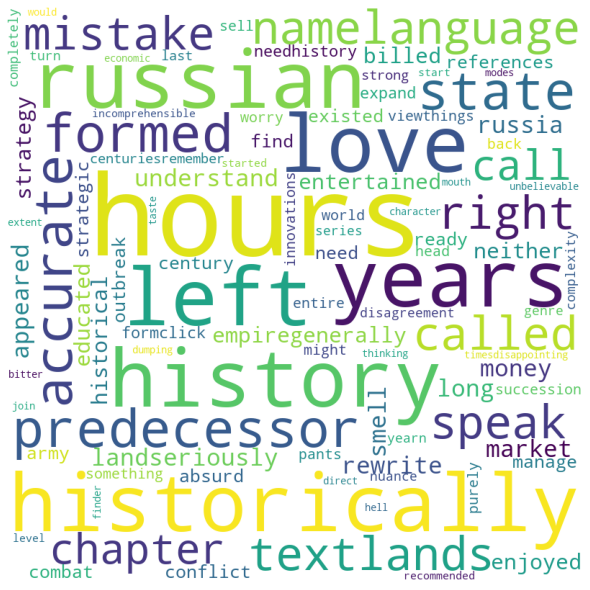

In [13]:
##Generating Word Cloud for Negative sentiment reviews
stopwords = set(STOPWORDS)

descriptions = list(Negative_text['review_text'])
all_words = ''

for i in range(0,10):
    tokens = descriptions[i]
    all_words += "".join(tokens)
    
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopword,
                min_font_size = 10).generate(all_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()    

# Bag of Words

In [14]:
###Forming Bag of Words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(new_data.review_text,new_data.review_label,test_size=.2,random_state=0)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

#cv = CountVectorizer(analyzer = 'word', stop_words=stopword,ngram_range=(2, 2),max_features=10000)
cv = CountVectorizer(analyzer = 'word', stop_words=stopword,max_features=10000)
X_train = cv.fit_transform(X_train)
X_test = cv.transform(X_test)

X_train

(420,) (106,) (420,) (106,)


<420x2044 sparse matrix of type '<class 'numpy.int64'>'
	with 6560 stored elements in Compressed Sparse Row format>

In [15]:
#Checking the distribution on train data
dist=pd.DataFrame(y_train.value_counts()/y_train.shape[0]).reset_index()
dist

,index,review_label
0,Positive,0.740476
1,Negative,0.171429
2,Neutral,0.088095


In [16]:
#Checking the distribution on test data
dist_test=pd.DataFrame(y_test.value_counts()/y_test.shape[0]).reset_index()
dist_test

,index,review_label
0,Positive,0.632075
1,Negative,0.188679
2,Neutral,0.179245


In [17]:
##Getting unique feature names from bag of words

feature_names = cv.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("features from 200 to 300:\n{}".format(feature_names[200:300]))


Number of features: 2044
features from 200 to 300:
['best', 'beta', 'better', 'beyond', 'bien', 'big', 'biggest', 'billed', 'bin', 'bit', 'bits', 'bland', 'blank', 'blasting', 'blend', 'blow', 'board', 'bonito', 'bonne', 'boosted', 'boot', 'bop', 'bored', 'boring', 'born', 'bothersome', 'boucle', 'bought', 'bounced', 'bound', 'box', 'boxes', 'brain', 'brand', 'break', 'breakfast', 'breaking', 'breath', 'breathtaking', 'brilliant', 'bring', 'brings', 'broke', 'broken', 'buddy', 'budget', 'buena', 'bueno', 'bug', 'buggy', 'bugs', 'build', 'builder', 'building', 'buildings', 'builds', 'built', 'bunch', 'buried', 'burnt', 'business', 'busted', 'busy', 'butter', 'buy', 'buying', 'bye', 'call', 'called', 'calling', 'came', 'camera', 'camp', 'campaign', 'cannibal', 'cant', 'capture', 'captured', 'cards', 'care', 'careful', 'caring', 'carrying', 'castle', 'casual', 'centuries', 'century', 'cerise', 'certain', 'certainly', 'challenge', 'challenger', 'challenging', 'chance', 'chances', 'change',

In [18]:
###Forming dataframe to dispaly vectors/ bag of words
pd.DataFrame(X_train.toarray())

,0,1,2,3,4,5,6,7,8,9,...,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
416,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
417,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
418,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


# Classification

In [19]:

###Logistic Regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.74


In [20]:
##Weight for Positive labels
round((dist[dist['index']=="Positive"]['review_label'])*100)

0    74.0
Name: review_label, dtype: float64

In [21]:
##Weight for Negative labels
round((dist[dist['index']=="Negative"]['review_label'])*100)

1    17.0
Name: review_label, dtype: float64

In [22]:
##Weight for Neutral labels
round((dist[dist['index']=="Neutral"]['review_label'])*100)

2    9.0
Name: review_label, dtype: float64

In [23]:
###Weighted Logistic regression
w = {'Positive':round((dist[dist['index']=="Positive"]['review_label'])*100), 'Negative':round((dist[dist['index']=="Negative"]['review_label'])*100),'Neutral':round((dist[dist['index']=="Neutral"]['review_label'])*100)}
logreg = LogisticRegression(random_state=13, class_weight=w)
#logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))


Training set score: 0.983
Test set score: 0.642


In [24]:
#Classification report for Logistic Regression 
log_predict=logreg.predict(X_test)
log_bow_report=classification_report(y_test,log_predict,target_names=['Neutral','Negative','Positive'])
print(log_bow_report)


              precision    recall  f1-score   support

     Neutral       0.50      0.05      0.09        20
    Negative       0.00      0.00      0.00        19
    Positive       0.64      1.00      0.78        67

    accuracy                           0.64       106
   macro avg       0.38      0.35      0.29       106
weighted avg       0.50      0.64      0.51       106



C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

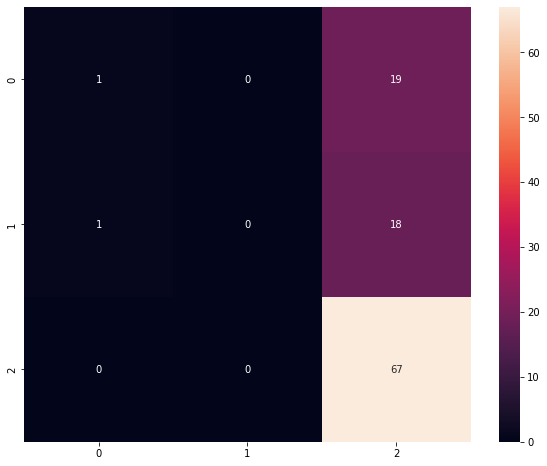

In [25]:
#Confusion Matrix Plot
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, log_predict)
plt.figure(figsize=(10, 8))
sns.heatmap(mat, annot=True)

In [26]:
###Running Random Forest classifier

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

rfc.score(X_test, y_test)
print("Training set score: {:.3f}".format(rfc.score(X_train, y_train)))
print("Test set score: {:.3f}".format(rfc.score(X_test, y_test)))


Training set score: 0.983
Test set score: 0.632


In [27]:
#Classification report for Random Forest Classifier
rfc_predict=rfc.predict(X_test)
rf_bow_report=classification_report(y_test,rfc_predict,target_names=['Neutral','Negative','Positive'])
print(rf_bow_report)

              precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00        20
    Negative       0.00      0.00      0.00        19
    Positive       0.63      1.00      0.77        67

    accuracy                           0.63       106
   macro avg       0.21      0.33      0.26       106
weighted avg       0.40      0.63      0.49       106



C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

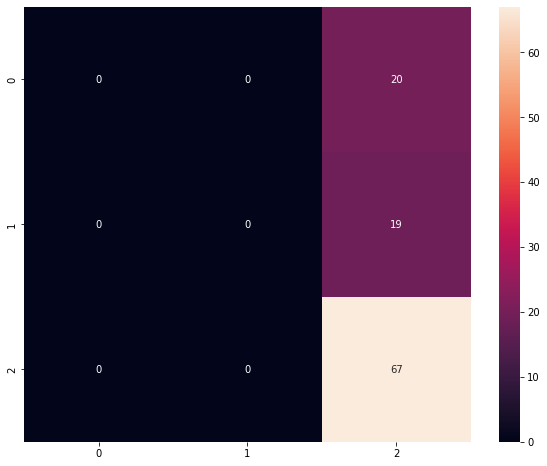

In [28]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, rfc_predict)
plt.figure(figsize=(10, 8))
sns.heatmap(mat, annot=True)

# Regression


In [29]:

###Running regression to predict score ratings based on user comments
X_train,X_test,y_train,y_test = train_test_split(new_data.review_text,new_data.review_score,test_size=.2)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)



(420,) (106,) (420,) (106,)


In [30]:
cv = CountVectorizer(analyzer = 'word', stop_words=stopword,max_features=10000)

X_train = cv.fit_transform(X_train)
X_test = cv.transform(X_test)

X_train

<420x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 6536 stored elements in Compressed Sparse Row format>

In [31]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 50)
 
regressor.fit(X_train, y_train)

regressor.score(X_test, y_test)
print("Training set score: {:.3f}".format(regressor.score(X_train, y_train)))
print("Test set score: {:.3f}".format(regressor.score(X_test, y_test)))

### Regression accuracy is bad as of now..need to improve it

Training set score: 0.829
Test set score: 0.024
